In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import ConvexHull
from numpy.linalg import eigvalsh
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from collections import defaultdict

---
---

In [5]:
dataset_folder = 'nuScenes'

df = pd.read_csv(dataset_folder + "/radar_points_with_annotations.csv")
df.head()

,sample_token,radar_channel,annotation,annotation_token,instance_token,num_sample,timestamp,utc_timestamp,scene_name,file_name,...,vx_comp,vy_comp,is_quality_valid,ambig_state,x_rms,y_rms,invalid_state,pdh0,vx_rms,vy_rms
0,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT,vehicle.truck,acce0b7220754600b700257a1de1573d,39b6c31c9925492a8a9f1b0ef3b877b6,0,1531883530440378,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...,...,0.232096,0.116048,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
1,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT,vehicle.truck,acce0b7220754600b700257a1de1573d,39b6c31c9925492a8a9f1b0ef3b877b6,0,1531883530440378,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...,...,0.200331,0.091615,1.0,3.0,19.0,19.0,0.0,1.0,16.0,3.0
2,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT,vehicle.truck,acce0b7220754600b700257a1de1573d,39b6c31c9925492a8a9f1b0ef3b877b6,0,1531883530440378,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...,...,0.021002,0.013872,1.0,3.0,19.0,19.0,0.0,1.0,17.0,3.0
3,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT,vehicle.truck,acce0b7220754600b700257a1de1573d,39b6c31c9925492a8a9f1b0ef3b877b6,0,1531883530440378,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...,...,0.078590,0.051941,1.0,3.0,19.0,19.0,0.0,1.0,17.0,3.0
4,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT_LEFT,vehicle.truck,acce0b7220754600b700257a1de1573d,39b6c31c9925492a8a9f1b0ef3b877b6,0,1531883530486381,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT_LEFT/n015-2018-07-18-11-07...,...,2.534241,-4.172758,1.0,3.0,20.0,20.0,0.0,1.0,19.0,3.0


---

In [6]:
print(f"Dataset shape: {df.shape}")
print(f"\nColumns in the dataset: {df.columns.tolist()}")

missing_values = df.isnull().sum()
print("\nMissing values by column:")
print(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values")

duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

Dataset shape: (659412, 28)

Columns in the dataset: ['sample_token', 'radar_channel', 'annotation', 'annotation_token', 'instance_token', 'num_sample', 'timestamp', 'utc_timestamp', 'scene_name', 'file_name', 'x_radar', 'y_radar', 'z_radar', 'dyn_prop', 'id', 'rcs', 'vx', 'vy', 'vx_comp', 'vy_comp', 'is_quality_valid', 'ambig_state', 'x_rms', 'y_rms', 'invalid_state', 'pdh0', 'vx_rms', 'vy_rms']

Missing values by column:
No missing values

Duplicate rows: 0


In [ ]:
print("Sample data point:")
print(df.iloc[0])

if 'annotation' in df.columns:
    print("\nUnique annotation values:")
    print(df['annotation'].value_counts())

if 'instance_token' in df.columns:
    print(f"\nNumber of unique instances: {df['instance_token'].nunique()}")

if 'radar_channel' in df.columns:
    print("\nSensor distribution:")
    print(df['radar_channel'].value_counts())

Sample data point:
sample_token                         e93e98b63d3b40209056d129dc53ceee
radar_channel                                             RADAR_FRONT
annotation                                              vehicle.truck
annotation_token                     acce0b7220754600b700257a1de1573d
instance_token                       39b6c31c9925492a8a9f1b0ef3b877b6
num_sample                                                          0
timestamp                                            1531883530440378
utc_timestamp                                     2018-07-18 03:12:10
scene_name                                                 scene-0001
file_name           samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...
x_radar                                                          15.0
y_radar                                                           7.5
z_radar                                                           0.0
dyn_prop                                                          1.0
i

---

In [11]:
group_classes = {
    "Car": ["vehicle.car"],
    "Large Vehicles": [
        "vehicle.truck", "vehicle.bus", "vehicle.bus.bendy", "vehicle.bus.rigid",
        "vehicle.emergency.ambulance", "vehicle.construction", "vehicle.trailer"
    ],
    "Twowheels": ["vehicle.motorcycle", "vehicle.bicycle"],
    "Pedestrian": ["human.pedestrian.adult", "human.pedestrian.child", "human.pedestrian.construction_worker", 
                  "human.pedestrian.police_officer", "human.pedestrian.wheelchair"],
}

def map_to_group(original_class):
    for group_name, classes in group_classes.items():
        if original_class in classes:
            return group_name
    return "Other"  # Default group for any classes not explicitly listed

# Check the original class distribution
if 'annotation' in df.columns:
    # Create a new column with grouped classes
    df['class_group'] = df['annotation'].apply(map_to_group)
    
    print("Grouped class distribution:")
    print(df['class_group'].value_counts())

Grouped class distribution:
class_group
Car               359211
Large Vehicles    230549
Other              42777
Pedestrian         19746
Twowheels           7129
Name: count, dtype: int64


---

In [12]:
def compute_cluster_features(cluster):
    """
    Compute statistical features for a cluster of radar points.
    
    Args:
        cluster (DataFrame): Cluster of radar points with the same timestamp and instance_token
        
    Returns:
        dict: Dictionary of computed features
    """
    features = {}
    
    # Basic count feature
    features['n_points'] = len(cluster)
    
    # Position features
    if 'x_radar' in cluster.columns and 'y_radar' in cluster.columns and 'z_radar' in cluster.columns:
        x = cluster['x_radar']
        y = cluster['y_radar']
        z = cluster['z_radar']
        
        features['x_min'] = x.min()
        features['x_max'] = x.max()
        features['x_mean'] = x.mean()
        features['x_std'] = x.std()
        features['x_spread'] = features['x_max'] - features['x_min']
        
        features['y_min'] = y.min()
        features['y_max'] = y.max()
        features['y_mean'] = y.mean()
        features['y_std'] = y.std()
        features['y_spread'] = features['y_max'] - features['y_min']
        
        features['z_min'] = z.min()
        features['z_max'] = z.max()
        features['z_mean'] = z.mean()
        features['z_std'] = z.std()
        features['z_spread'] = features['z_max'] - features['z_min']
        
        # Distance to origin (ego vehicle)
        centroid_x = features['x_mean']
        centroid_y = features['y_mean']
        centroid_z = features['z_mean']
        features['distance_to_origin'] = np.sqrt(centroid_x**2 + centroid_y**2 + centroid_z**2)
        
        # Bounding box features
        features['bbox_area_xy'] = features['x_spread'] * features['y_spread']
        features['bbox_volume'] = features['x_spread'] * features['y_spread'] * features['z_spread']
        
        # Compute covariance features only if we have enough points
        if len(x) >= 3:
            # 2D features (xy plane)
            xy = np.vstack((x, y)).T
            
            # Covariance eigenvalues (shape features)
            cov_xy = np.cov(xy, rowvar=False)
            if cov_xy.shape == (2, 2):  # Ensure we have a valid 2x2 covariance matrix
                eigvals_xy = eigvalsh(cov_xy)
                features['cov_ev_major_xy'] = eigvals_xy[-1]  # Largest eigenvalue
                features['cov_ev_minor_xy'] = eigvals_xy[0]   # Smallest eigenvalue
                features['cov_ev_ratio_xy'] = eigvals_xy[-1] / (eigvals_xy[0] + 1e-10)  # Ratio (avoid division by zero)
            
            # Convex hull features (if enough points)
            try:
                hull_xy = ConvexHull(xy)
                features['convex_hull_area'] = hull_xy.volume  # In 2D, volume is area
                features['convex_hull_perimeter'] = hull_xy.area  # In 2D, area is perimeter
                features['point_density_xy'] = len(xy) / hull_xy.volume if hull_xy.volume > 0 else 0
                
                # Circularity (compactness) - isoperimetric quotient
                if hull_xy.area > 0:
                    circ = 4 * np.pi * hull_xy.volume / (hull_xy.area ** 2)
                    features['circularity'] = circ
                else:
                    features['circularity'] = 0
            except:
                features['convex_hull_area'] = 0
                features['convex_hull_perimeter'] = 0
                features['point_density_xy'] = 0
                features['circularity'] = 0
            
            # 3D features if enough points
            if len(x) >= 4:
                xyz = np.vstack((x, y, z)).T
                
                try:
                    # 3D covariance eigenvalues
                    cov_xyz = np.cov(xyz, rowvar=False)
                    if cov_xyz.shape == (3, 3):
                        eigvals_xyz = eigvalsh(cov_xyz)
                        features['cov_ev_major_xyz'] = eigvals_xyz[-1]  # Largest eigenvalue
                        features['cov_ev_middle_xyz'] = eigvals_xyz[1]  # Middle eigenvalue
                        features['cov_ev_minor_xyz'] = eigvals_xyz[0]   # Smallest eigenvalue
                        
                        # Shape factors
                        features['flatness'] = (eigvals_xyz[1] - eigvals_xyz[0]) / (eigvals_xyz[2] + 1e-10)
                        features['linearity'] = (eigvals_xyz[2] - eigvals_xyz[1]) / (eigvals_xyz[2] + 1e-10)
                        features['sphericity'] = eigvals_xyz[0] / (eigvals_xyz[2] + 1e-10)
                except:
                    features['cov_ev_major_xyz'] = 0
                    features['cov_ev_middle_xyz'] = 0
                    features['cov_ev_minor_xyz'] = 0
                    features['flatness'] = 0
                    features['linearity'] = 0
                    features['sphericity'] = 0
            else:
                features['cov_ev_major_xyz'] = 0
                features['cov_ev_middle_xyz'] = 0
                features['cov_ev_minor_xyz'] = 0
                features['flatness'] = 0
                features['linearity'] = 0
                features['sphericity'] = 0
        else:
            # Default values if not enough points
            features['cov_ev_major_xy'] = 0
            features['cov_ev_minor_xy'] = 0
            features['cov_ev_ratio_xy'] = 0
            features['convex_hull_area'] = 0
            features['convex_hull_perimeter'] = 0
            features['point_density_xy'] = 0
            features['circularity'] = 0
            features['cov_ev_major_xyz'] = 0
            features['cov_ev_middle_xyz'] = 0
            features['cov_ev_minor_xyz'] = 0
            features['flatness'] = 0
            features['linearity'] = 0
            features['sphericity'] = 0
    
    # Velocity features
    if 'vx' in cluster.columns and 'vy' in cluster.columns:
        vx = cluster['vx']
        vy = cluster['vy']
        
        features['vx_min'] = vx.min()
        features['vx_max'] = vx.max()
        features['vx_mean'] = vx.mean()
        features['vx_std'] = vx.std()
        features['vx_spread'] = features['vx_max'] - features['vx_min']
        
        features['vy_min'] = vy.min()
        features['vy_max'] = vy.max()
        features['vy_mean'] = vy.mean()
        features['vy_std'] = vy.std()
        features['vy_spread'] = features['vy_max'] - features['vy_min']
        
        # Speed and direction
        v_mag = np.sqrt(vx**2 + vy**2)
        features['speed_min'] = v_mag.min()
        features['speed_max'] = v_mag.max()
        features['speed_mean'] = v_mag.mean()
        features['speed_std'] = v_mag.std()
    
    # Compensated velocity features
    if 'vx_comp' in cluster.columns and 'vy_comp' in cluster.columns:
        vx_comp = cluster['vx_comp']
        vy_comp = cluster['vy_comp']
        
        features['vx_comp_min'] = vx_comp.min()
        features['vx_comp_max'] = vx_comp.max()
        features['vx_comp_mean'] = vx_comp.mean()
        features['vx_comp_std'] = vx_comp.std()
        features['vx_comp_spread'] = features['vx_comp_max'] - features['vx_comp_min']
        
        features['vy_comp_min'] = vy_comp.min()
        features['vy_comp_max'] = vy_comp.max()
        features['vy_comp_mean'] = vy_comp.mean()
        features['vy_comp_std'] = vy_comp.std()
        features['vy_comp_spread'] = features['vy_comp_max'] - features['vy_comp_min']
        
        # Compensated speed
        v_comp_mag = np.sqrt(vx_comp**2 + vy_comp**2)
        features['speed_comp_min'] = v_comp_mag.min()
        features['speed_comp_max'] = v_comp_mag.max()
        features['speed_comp_mean'] = v_comp_mag.mean()
        features['speed_comp_std'] = v_comp_mag.std()
        
        # Percentage of stationary points
        features['stationary_ratio'] = (v_comp_mag < 0.1).mean()
    
    # RCS features
    if 'rcs' in cluster.columns:
        rcs = cluster['rcs']
        features['rcs_min'] = rcs.min()
        features['rcs_max'] = rcs.max()
        features['rcs_mean'] = rcs.mean()
        features['rcs_std'] = rcs.std()
        features['rcs_spread'] = features['rcs_max'] - features['rcs_min']
    
    # Dynamic properties if available
    if 'dyn_prop' in cluster.columns:
        dyn_prop = cluster['dyn_prop']
        features['dyn_prop_mode'] = dyn_prop.mode()[0] if not dyn_prop.empty else 0
        dyn_prop_counts = dyn_prop.value_counts(normalize=True)
        for val in sorted(dyn_prop_counts.index):
            features[f'dyn_prop_{val}_ratio'] = dyn_prop_counts.get(val, 0)
    
    # Quality metrics if available
    if 'is_quality_valid' in cluster.columns:
        features['quality_valid_ratio'] = cluster['is_quality_valid'].mean()
    
    if 'invalid_state' in cluster.columns:
        features['invalid_state_ratio'] = cluster['invalid_state'].mean()
    
    # Ambiguity state if available
    if 'ambig_state' in cluster.columns:
        ambig_state = cluster['ambig_state']
        features['ambig_state_mode'] = ambig_state.mode()[0] if not ambig_state.empty else 0
        ambig_state_counts = ambig_state.value_counts(normalize=True)
        for val in sorted(ambig_state_counts.index):
            features[f'ambig_state_{val}_ratio'] = ambig_state_counts.get(val, 0)
    
    # RMS values (uncertainties) if available
    if 'x_rms' in cluster.columns and 'y_rms' in cluster.columns:
        features['x_rms_mean'] = cluster['x_rms'].mean()
        features['y_rms_mean'] = cluster['y_rms'].mean()
        
        # Position uncertainty (average)
        pos_uncertainty = np.sqrt(cluster['x_rms']**2 + cluster['y_rms']**2)
        features['pos_uncertainty_mean'] = pos_uncertainty.mean()
        features['pos_uncertainty_max'] = pos_uncertainty.max()
    
    if 'vx_rms' in cluster.columns and 'vy_rms' in cluster.columns:
        features['vx_rms_mean'] = cluster['vx_rms'].mean()
        features['vy_rms_mean'] = cluster['vy_rms'].mean()
        
        # Velocity uncertainty (average)
        vel_uncertainty = np.sqrt(cluster['vx_rms']**2 + cluster['vy_rms']**2)
        features['vel_uncertainty_mean'] = vel_uncertainty.mean()
        features['vel_uncertainty_max'] = vel_uncertainty.max()
    
    return features

In [13]:
df.columns

Index(['sample_token', 'radar_channel', 'annotation', 'annotation_token',
       'instance_token', 'num_sample', 'timestamp', 'utc_timestamp',
       'scene_name', 'file_name', 'x_radar', 'y_radar', 'z_radar', 'dyn_prop',
       'id', 'rcs', 'vx', 'vy', 'vx_comp', 'vy_comp', 'is_quality_valid',
       'ambig_state', 'x_rms', 'y_rms', 'invalid_state', 'pdh0', 'vx_rms',
       'vy_rms', 'class_group'],
      dtype='object')

In [14]:
df_subset = df  # Use the full dataset

# Group by instance_token and timestamp
grouped = df_subset.groupby(['instance_token', 'timestamp', 'radar_channel'])

print(f"Found {len(grouped)} unique clusters (objects)")

print("Extracting features for each cluster...")
all_features = []
for (instance_token, timestamp, radar_channel), group in tqdm(grouped):
    try:    
        features = compute_cluster_features(group)
        
        # Add identifying information
        features['instance_token'] = instance_token
        features['timestamp'] = timestamp
        features['radar_channel'] = radar_channel
        
        # Add annotation information if available
        if 'annotation' in group.columns and not group['annotation'].isnull().all():
            original_annotation = group['annotation'].iloc[0]
            features['original_annotation'] = original_annotation
            
            # Add the grouped class label
            if 'class_group' in group.columns:
                features['annotation'] = group['class_group'].iloc[0]
            else:
                # If class_group column doesn't exist, map it directly
                features['annotation'] = map_to_group(original_annotation)
        
        # Add scene information if available
        if 'scene_name' in group.columns:
            features['scene_name'] = group['scene_name'].iloc[0]
            
        all_features.append(features)
    except Exception as e:
        print(f"Error processing cluster ({instance_token}, {timestamp}): {str(e)}")

# Convert all features to DataFrame
features_df = pd.DataFrame(all_features)

# Display information about the created dataset
print(f"\nCreated classification dataset with {len(features_df)} samples and {features_df.shape[1]} features")
print(f"Feature columns: {features_df.columns.tolist()}")

# Display class distribution if available
if 'annotation' in features_df.columns:
    label_counts = features_df['annotation'].value_counts()
    print("\nClass distribution:")
    print(label_counts)

# Display a sample of the dataset
print("\nSample of the dataset:")
features_df.head()

Found 395341 unique clusters (objects)
Extracting features for each cluster...


  0%|          | 0/395341 [00:00<?, ?it/s]


Created classification dataset with 395341 samples and 91 features
Feature columns: ['n_points', 'x_min', 'x_max', 'x_mean', 'x_std', 'x_spread', 'y_min', 'y_max', 'y_mean', 'y_std', 'y_spread', 'z_min', 'z_max', 'z_mean', 'z_std', 'z_spread', 'distance_to_origin', 'bbox_area_xy', 'bbox_volume', 'cov_ev_major_xy', 'cov_ev_minor_xy', 'cov_ev_ratio_xy', 'convex_hull_area', 'convex_hull_perimeter', 'point_density_xy', 'circularity', 'cov_ev_major_xyz', 'cov_ev_middle_xyz', 'cov_ev_minor_xyz', 'flatness', 'linearity', 'sphericity', 'vx_min', 'vx_max', 'vx_mean', 'vx_std', 'vx_spread', 'vy_min', 'vy_max', 'vy_mean', 'vy_std', 'vy_spread', 'speed_min', 'speed_max', 'speed_mean', 'speed_std', 'vx_comp_min', 'vx_comp_max', 'vx_comp_mean', 'vx_comp_std', 'vx_comp_spread', 'vy_comp_min', 'vy_comp_max', 'vy_comp_mean', 'vy_comp_std', 'vy_comp_spread', 'speed_comp_min', 'speed_comp_max', 'speed_comp_mean', 'speed_comp_std', 'stationary_ratio', 'rcs_min', 'rcs_max', 'rcs_mean', 'rcs_std', 'rcs_spr

,n_points,x_min,x_max,x_mean,x_std,x_spread,y_min,y_max,y_mean,y_std,...,timestamp,radar_channel,original_annotation,annotation,scene_name,dyn_prop_6.0_ratio,dyn_prop_5.0_ratio,dyn_prop_3.0_ratio,dyn_prop_0.0_ratio,dyn_prop_2.0_ratio
0,1,8.000000,8.000000,8.000000,NaN,0.0,7.700000,7.700000,7.700000,NaN,...,1535488002796885,RADAR_BACK_LEFT,movable_object.barrier,Other,scene-0678,NaN,NaN,NaN,NaN,NaN
1,1,30.000000,30.000000,30.000000,NaN,0.0,23.900000,23.900000,23.900000,NaN,...,1533153488714963,RADAR_FRONT,vehicle.car,Car,scene-0069,NaN,NaN,NaN,NaN,NaN
2,1,21.200001,21.200001,21.200001,NaN,0.0,24.299999,24.299999,24.299999,NaN,...,1533153490175374,RADAR_FRONT,vehicle.car,Car,scene-0069,NaN,NaN,NaN,NaN,NaN
3,1,23.200001,23.200001,23.200001,NaN,0.0,-10.700000,-10.700000,-10.700000,NaN,...,1533153491177819,RADAR_FRONT_LEFT,vehicle.car,Car,scene-0069,1.0,NaN,NaN,NaN,NaN
4,2,23.400000,23.400000,23.400000,0.0,0.0,-2.900000,-2.300000,-2.600000,0.424264,...,1533153492228656,RADAR_FRONT_LEFT,vehicle.car,Car,scene-0069,0.5,0.5,NaN,NaN,NaN


---

In [16]:
missing_values = features_df.isnull().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])
numeric_cols = features_df.select_dtypes(include=[np.number]).columns
features_df[numeric_cols] = features_df[numeric_cols].fillna(features_df[numeric_cols].median())

inf_values = np.isinf(features_df.select_dtypes(include=[np.number])).sum()
print("\nColumns with infinite values:")
print(inf_values[inf_values > 0])
features_df = features_df.replace([np.inf, -np.inf], np.nan)

Columns with missing values:
Series([], dtype: int64)

Columns with infinite values:
Series([], dtype: int64)


In [17]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395341 entries, 0 to 395340
Data columns (total 91 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   n_points               395341 non-null  int64  
 1   x_min                  395341 non-null  float64
 2   x_max                  395341 non-null  float64
 3   x_mean                 395341 non-null  float64
 4   x_std                  395341 non-null  float64
 5   x_spread               395341 non-null  float64
 6   y_min                  395341 non-null  float64
 7   y_max                  395341 non-null  float64
 8   y_mean                 395341 non-null  float64
 9   y_std                  395341 non-null  float64
 10  y_spread               395341 non-null  float64
 11  z_min                  395341 non-null  float64
 12  z_max                  395341 non-null  float64
 13  z_mean                 395341 non-null  float64
 14  z_std                  395341 non-nu

In [18]:
features_df.describe()

,n_points,x_min,x_max,x_mean,x_std,x_spread,y_min,y_max,y_mean,y_std,...,vx_rms_mean,vy_rms_mean,vel_uncertainty_mean,vel_uncertainty_max,timestamp,dyn_prop_6.0_ratio,dyn_prop_5.0_ratio,dyn_prop_3.0_ratio,dyn_prop_0.0_ratio,dyn_prop_2.0_ratio
count,395341.000000,395341.000000,395341.000000,395341.000000,395341.000000,395341.000000,395341.000000,395341.000000,395341.000000,395341.000000,...,395341.000000,395341.0,395341.000000,395341.000000,3.953410e+05,395341.000000,395341.000000,395341.000000,395341.000000,395341.000000
mean,1.667958,25.329145,26.149694,25.717201,0.953384,0.820549,-0.491108,-0.020537,-0.255887,0.523750,...,16.332108,3.0,16.605721,16.641420,1.535531e+15,0.993451,0.995357,0.985950,0.995407,0.995412
std,1.199432,18.531594,18.532037,18.513172,0.815103,1.889769,10.350701,10.367908,10.335622,0.527845,...,0.620908,0.0,0.611405,0.663539,2.882797e+12,0.061592,0.051723,0.092695,0.051650,0.051433
min,1.000000,0.800000,0.800000,0.800000,0.000000,0.000000,-86.699997,-86.699997,-86.699997,0.000000,...,16.000000,3.0,16.278821,16.278821,1.526915e+15,0.047619,0.062500,0.045455,0.045455,0.066667
25%,1.000000,11.800000,12.600000,12.200000,0.808290,0.000000,-6.100000,-5.700000,-5.900000,0.424264,...,16.000000,3.0,16.278821,16.278821,1.533203e+15,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,20.600000,21.400000,20.900001,0.808290,0.000000,-0.100000,0.100000,-0.100000,0.424264,...,16.000000,3.0,16.278821,16.278821,1.535640e+15,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,34.000000,34.799999,34.400002,0.808290,0.600000,5.300000,5.700000,5.500000,0.424264,...,16.571429,3.0,16.841024,17.262677,1.537296e+15,1.000000,1.000000,1.000000,1.000000,1.000000
max,25.000000,251.600006,251.600006,251.600006,13.674672,31.799999,100.500000,100.500000,100.500000,11.879395,...,22.000000,3.0,22.203603,22.203603,1.542802e+15,1.000000,1.000000,1.000000,1.000000,1.000000


---

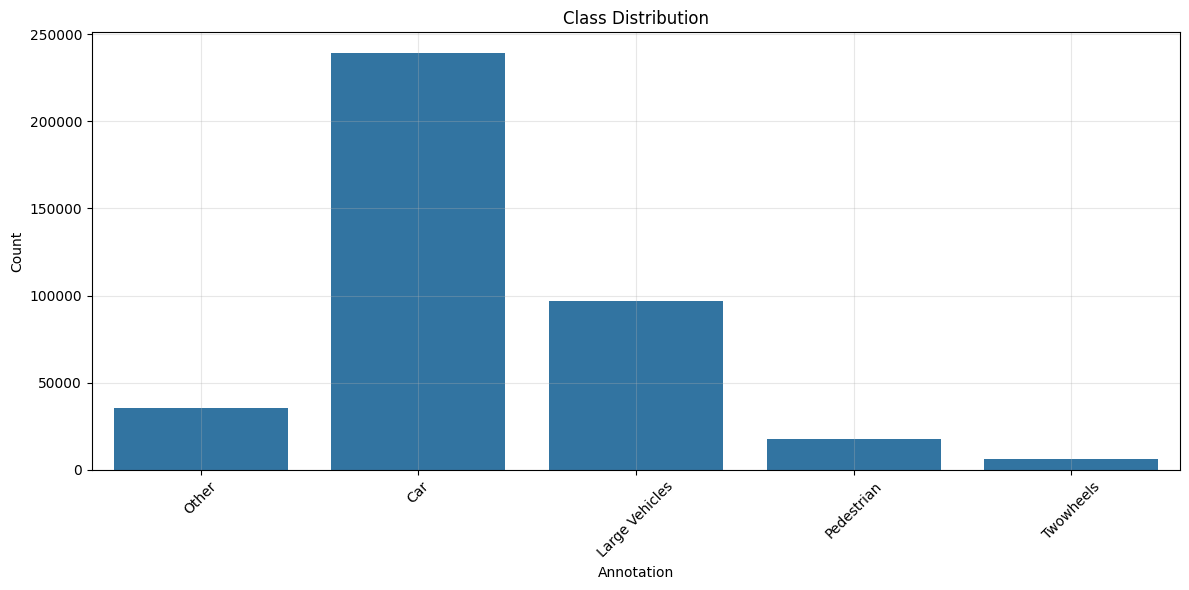

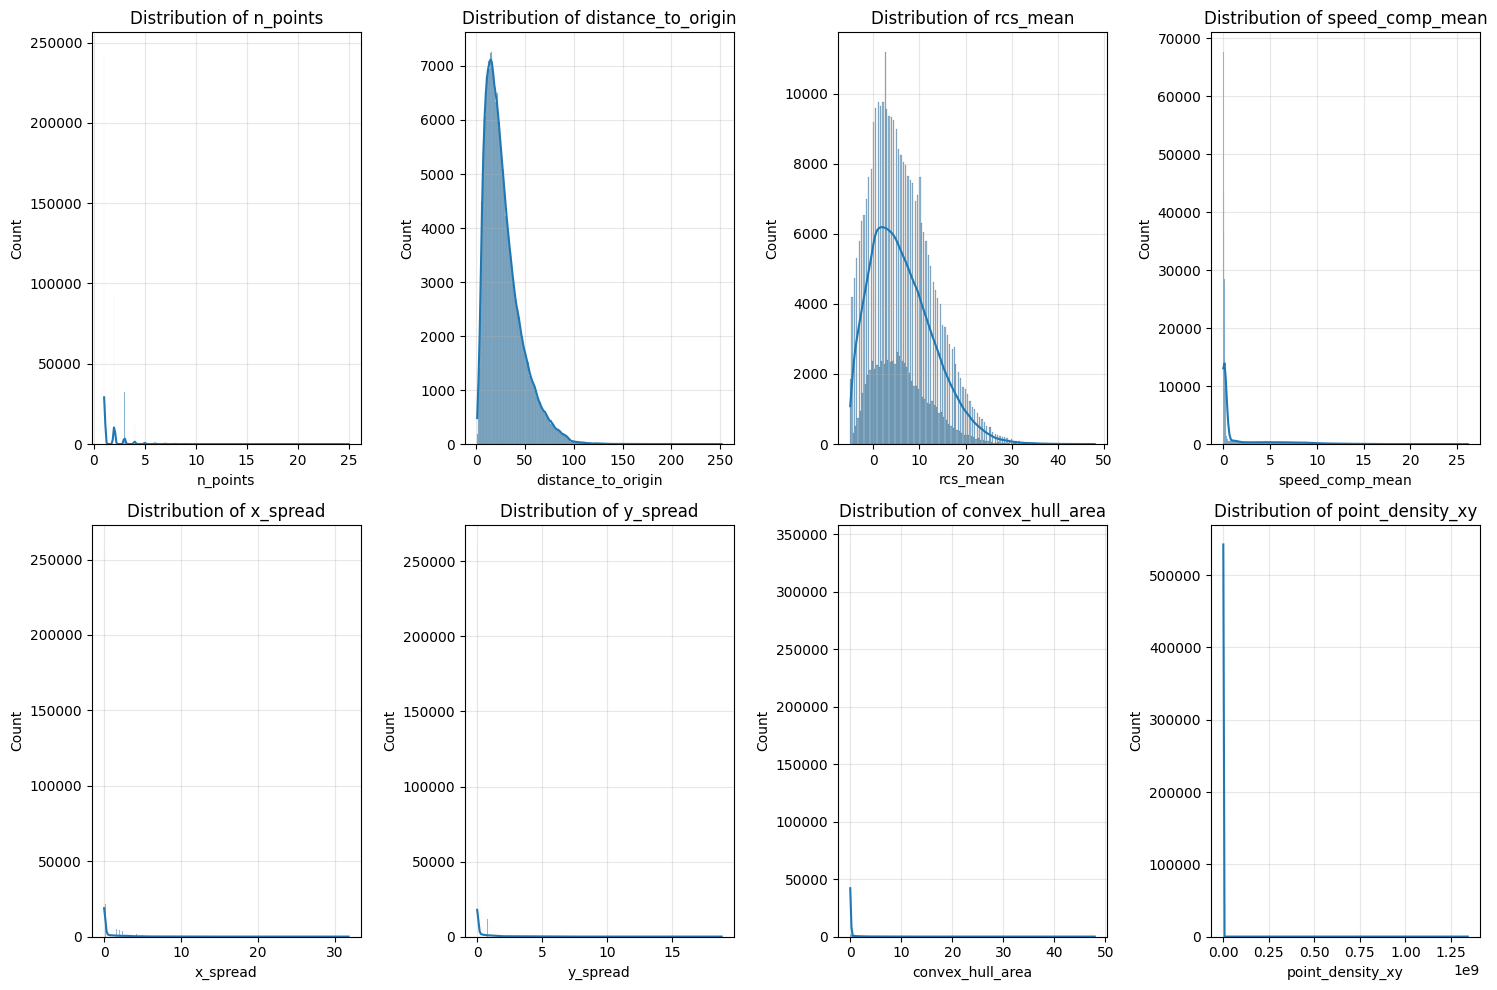

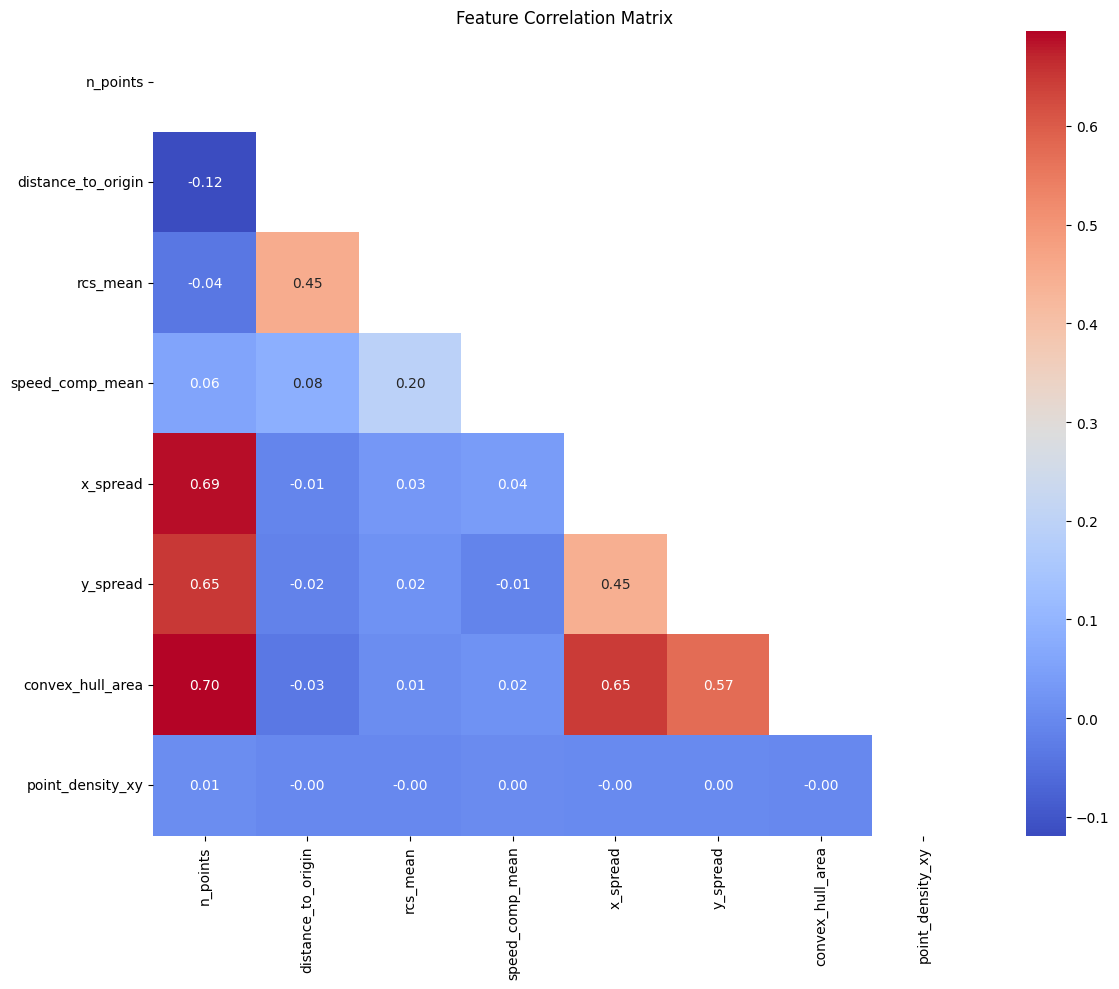

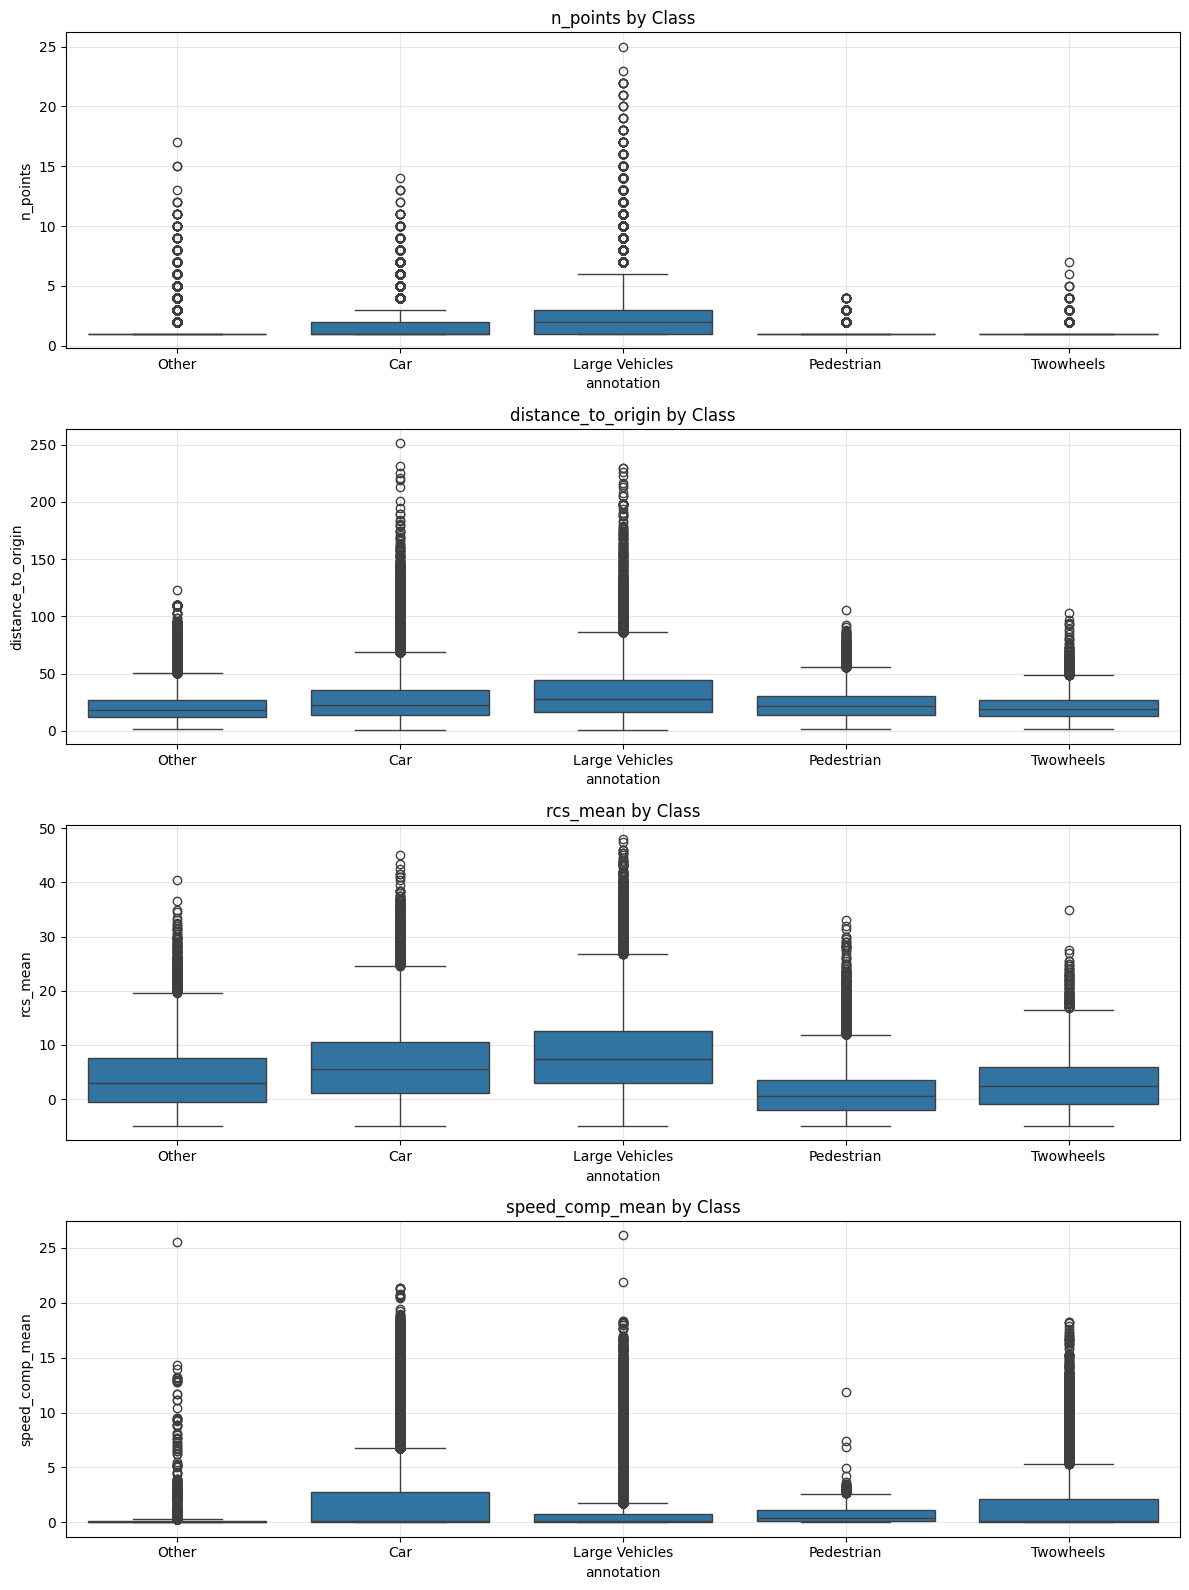

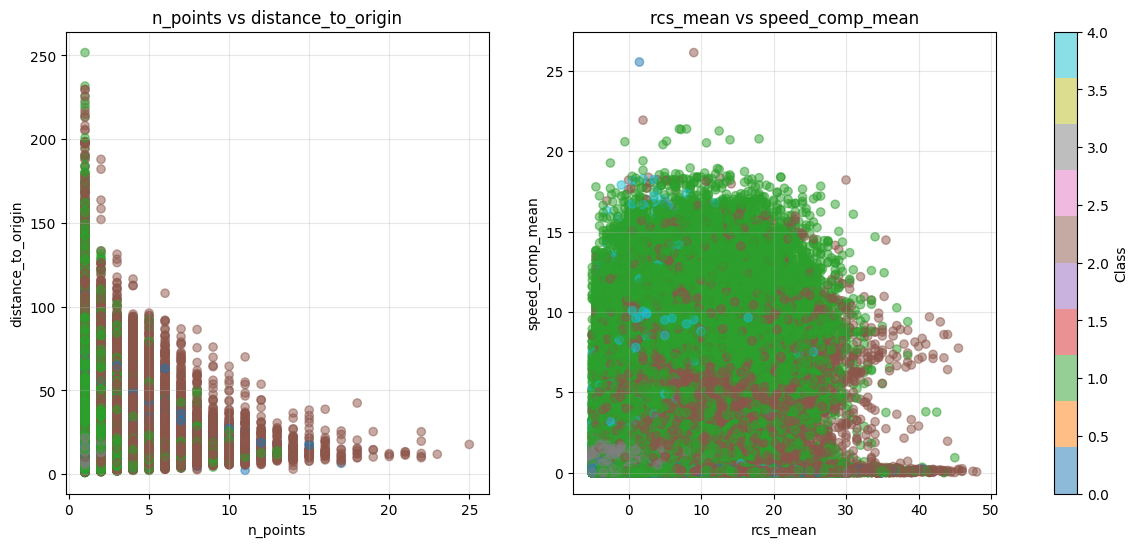

In [22]:
if 'annotation' in features_df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(x='annotation', data=features_df)
    plt.title('Class Distribution')
    plt.xlabel('Annotation')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

important_features = [
    'n_points', 'distance_to_origin', 'rcs_mean', 'speed_comp_mean', 
    'x_spread', 'y_spread', 'convex_hull_area', 'point_density_xy'
]

plot_features = [f for f in important_features if f in features_df.columns]

if plot_features:
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(plot_features):
        plt.subplot(2, 4, i+1)
        sns.histplot(features_df[feature], kde=True)
        plt.title(f'Distribution of {feature}')
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if len(plot_features) > 1:
    plt.figure(figsize=(12, 10))
    corr_matrix = features_df[plot_features].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

if 'annotation' in features_df.columns and len(plot_features) > 0:
    # Get the most common classes for clarity
    top_classes = features_df['annotation'].value_counts().head(5).index.tolist()
    df_subset = features_df[features_df['annotation'].isin(top_classes)]
    
    # Select a smaller subset of features for clarity
    boxplot_features = plot_features[:4]  # Take first 4 features
    
    fig, axes = plt.subplots(len(boxplot_features), 1, figsize=(12, 4*len(boxplot_features)))
    
    for i, feature in enumerate(boxplot_features):
        ax = axes[i] if len(boxplot_features) > 1 else axes
        sns.boxplot(x='annotation', y=feature, data=df_subset, ax=ax)
        ax.set_title(f'{feature} by Class')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 2D scatter plots of selected feature pairs, colored by class
if 'annotation' in features_df.columns and len(plot_features) >= 2:
    # Use the subset with top classes for clarity
    if 'df_subset' not in locals():
        top_classes = features_df['annotation'].value_counts().head(5).index.tolist()
        df_subset = features_df[features_df['annotation'].isin(top_classes)]
    
    # Select a few feature pairs for visualization
    feature_pairs = [
        (plot_features[0], plot_features[1]),
        (plot_features[2], plot_features[3]) if len(plot_features) > 3 else (plot_features[0], plot_features[2])
    ]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    for i, (feat1, feat2) in enumerate(feature_pairs):
        scatter = axes[i].scatter(
            df_subset[feat1], 
            df_subset[feat2], 
            c=pd.factorize(df_subset['annotation'])[0], 
            alpha=0.5, 
            cmap='tab10'
        )
        axes[i].set_xlabel(feat1)
        axes[i].set_ylabel(feat2)
        axes[i].set_title(f'{feat1} vs {feat2}')
        axes[i].grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=axes, label='Class')
    plt.show()

---

In [25]:
output_csv_path = 'nuscenes_objects_features_classification.csv'
features_df.to_csv(output_csv_path, index=False)
print(f"Full classification dataset saved to: {output_csv_path}")

Full classification dataset saved to: nuscenes_objects_features_classification.csv


In [26]:
# Create a smaller version with only key features for quick testing
# Select important identifier columns
id_columns = ['instance_token', 'timestamp', 'scene_name']

if 'annotation' in features_df.columns:
    id_columns.append('annotation')

# Also include the original annotation if available
if 'original_annotation' in features_df.columns:
    id_columns.append('original_annotation')

if 'sensor' in features_df.columns:
    id_columns.append('sensor')

# Select a subset of important features (if they exist in our dataset)
feature_subset = [
    'n_points', 'distance_to_origin', 
    'x_mean', 'y_mean', 'z_mean',
    'x_spread', 'y_spread', 'z_spread',
    'bbox_area_xy', 'bbox_volume',
    'speed_comp_mean', 'speed_comp_std',
    'rcs_mean', 'rcs_std',
    'cov_ev_major_xy', 'cov_ev_minor_xy', 'cov_ev_ratio_xy',
    'convex_hull_area', 'point_density_xy', 'circularity',
    'flatness', 'linearity', 'sphericity',
    'stationary_ratio', 'quality_valid_ratio'
]

# Filter to include only existing columns
existing_features = [f for f in feature_subset if f in features_df.columns]
selected_columns = id_columns + existing_features

# Create the subset dataframe
subset_df = features_df[selected_columns]

# Save the subset
subset_csv_path = 'nuscenes_objects_features_classification_subset.csv'
subset_df.to_csv(subset_csv_path, index=False)
print(f"Subset classification dataset saved to: {subset_csv_path}")

print(f"\nDataset shapes:")
print(f"- Full dataset: {features_df.shape}")
print(f"- Subset dataset: {subset_df.shape}")
print(f"Selected features for subset: {existing_features}")

Subset classification dataset saved to: nuscenes_objects_features_classification_subset.csv

Dataset shapes:
- Full dataset: (395341, 91)
- Subset dataset: (395341, 30)
Selected features for subset: ['n_points', 'distance_to_origin', 'x_mean', 'y_mean', 'z_mean', 'x_spread', 'y_spread', 'z_spread', 'bbox_area_xy', 'bbox_volume', 'speed_comp_mean', 'speed_comp_std', 'rcs_mean', 'rcs_std', 'cov_ev_major_xy', 'cov_ev_minor_xy', 'cov_ev_ratio_xy', 'convex_hull_area', 'point_density_xy', 'circularity', 'flatness', 'linearity', 'sphericity', 'stationary_ratio', 'quality_valid_ratio']


---
---

In [27]:
dataset_folder = 'nuScenes'

df = pd.read_csv(dataset_folder + "/radar_points_with_annotations_and_noise.csv")
df.head()

,sample_token,radar_channel,num_sample,timestamp,utc_timestamp,scene_name,file_name,x_radar,y_radar,z_radar,...,ambig_state,x_rms,y_rms,invalid_state,pdh0,vx_rms,vy_rms,annotation,annotation_token,instance_token
0,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT,0,1531883530440378,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...,8.4,-5.3,0.0,...,3.0,19.0,19.0,0.0,1.0,17.0,3.0,noise,NaN,NaN
1,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT,0,1531883530440378,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...,6.4,-10.5,0.0,...,3.0,19.0,19.0,0.0,1.0,19.0,3.0,noise,NaN,NaN
2,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT,0,1531883530440378,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...,9.4,-9.9,0.0,...,3.0,20.0,20.0,0.0,1.0,18.0,3.0,noise,NaN,NaN
3,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT,0,1531883530440378,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...,14.6,2.3,0.0,...,3.0,19.0,19.0,0.0,1.0,16.0,3.0,noise,NaN,NaN
4,e93e98b63d3b40209056d129dc53ceee,RADAR_FRONT,0,1531883530440378,2018-07-18 03:12:10,scene-0001,samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...,15.0,7.5,0.0,...,3.0,19.0,19.0,0.0,1.0,16.0,3.0,vehicle.truck,acce0b7220754600b700257a1de1573d,39b6c31c9925492a8a9f1b0ef3b877b6


---

In [28]:
print(f"Dataset shape: {df.shape}")
print(f"\nColumns in the dataset: {df.columns.tolist()}")

missing_values = df.isnull().sum()
print("\nMissing values by column:")
print(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values")

duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

Dataset shape: (6844098, 28)

Columns in the dataset: ['sample_token', 'radar_channel', 'num_sample', 'timestamp', 'utc_timestamp', 'scene_name', 'file_name', 'x_radar', 'y_radar', 'z_radar', 'dyn_prop', 'id', 'rcs', 'vx', 'vy', 'vx_comp', 'vy_comp', 'is_quality_valid', 'ambig_state', 'x_rms', 'y_rms', 'invalid_state', 'pdh0', 'vx_rms', 'vy_rms', 'annotation', 'annotation_token', 'instance_token']

Missing values by column:
annotation_token    6184686
instance_token      6184686
dtype: int64

Duplicate rows: 0


In [29]:
print("Sample data point:")
print(df.iloc[0])

if 'annotation' in df.columns:
    print("\nUnique annotation values:")
    print(df['annotation'].value_counts())

if 'instance_token' in df.columns:
    print(f"\nNumber of unique instances: {df['instance_token'].nunique()}")

if 'radar_channel' in df.columns:
    print("\nSensor distribution:")
    print(df['radar_channel'].value_counts())

Sample data point:
sample_token                         e93e98b63d3b40209056d129dc53ceee
radar_channel                                             RADAR_FRONT
num_sample                                                          0
timestamp                                            1531883530440378
utc_timestamp                                     2018-07-18 03:12:10
scene_name                                                 scene-0001
file_name           samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0...
x_radar                                                           8.4
y_radar                                                          -5.3
z_radar                                                           0.0
dyn_prop                                                          1.0
id                                                                0.0
rcs                                                              11.0
vx                                                              -5.75
v

---

In [30]:
feature_subset = [
    'n_points', 'distance_to_origin', 
    'x_mean', 'y_mean', 'z_mean',
    'x_spread', 'y_spread', 'z_spread',
    'bbox_area_xy', 'bbox_volume',
    'speed_comp_mean', 'speed_comp_std',
    'rcs_mean', 'rcs_std',
    'cov_ev_major_xy', 'cov_ev_minor_xy', 'cov_ev_ratio_xy',
    'convex_hull_area', 'point_density_xy', 'circularity',
    'flatness', 'linearity', 'sphericity',
    'stationary_ratio', 'quality_valid_ratio'
]

group_classes = {
    "Car": ["vehicle.car"],
    "Large Vehicles": [
        "vehicle.truck", "vehicle.bus", "vehicle.bus.bendy", "vehicle.bus.rigid",
        "vehicle.emergency.ambulance", "vehicle.construction", "vehicle.trailer"
    ],
    "Twowheels": ["vehicle.motorcycle", "vehicle.bicycle"],
    "Pedestrian": [
        "human.pedestrian.adult", "human.pedestrian.child", "human.pedestrian.construction_worker",
        "human.pedestrian.police_officer", "human.pedestrian.wheelchair"
    ],
    "Noise": ["noise"]
}

annotation_to_group = {}
for group, annots in group_classes.items():
    for annot in annots:
        annotation_to_group[annot] = group

def map_annotation(annotation):
    return annotation_to_group.get(annotation, "Other")

df['grouped_annotation'] = df['annotation'].apply(map_annotation)

---

In [ ]:
def compute_cluster_features(cluster):
    """
    Compute statistical features for a cluster of radar points.
    
    Args:
        cluster (DataFrame): Cluster of radar points with the same timestamp and instance_token
        
    Returns:
        dict: Dictionary of computed features
    """
    features = {}
    
    # Basic count feature
    features['n_points'] = len(cluster)
    
    # Position features
    if 'x_radar' in cluster.columns and 'y_radar' in cluster.columns and 'z_radar' in cluster.columns:
        x = cluster['x_radar']
        y = cluster['y_radar']
        z = cluster['z_radar']
        
        features['x_min'] = x.min()
        features['x_max'] = x.max()
        features['x_mean'] = x.mean()
        features['x_std'] = x.std()
        features['x_spread'] = features['x_max'] - features['x_min']
        
        features['y_min'] = y.min()
        features['y_max'] = y.max()
        features['y_mean'] = y.mean()
        features['y_std'] = y.std()
        features['y_spread'] = features['y_max'] - features['y_min']
        
        features['z_min'] = z.min()
        features['z_max'] = z.max()
        features['z_mean'] = z.mean()
        features['z_std'] = z.std()
        features['z_spread'] = features['z_max'] - features['z_min']
        
        # Distance to origin (ego vehicle)
        centroid_x = features['x_mean']
        centroid_y = features['y_mean']
        centroid_z = features['z_mean']
        features['distance_to_origin'] = np.sqrt(centroid_x**2 + centroid_y**2 + centroid_z**2)
        
        # Bounding box features
        features['bbox_area_xy'] = features['x_spread'] * features['y_spread']
        features['bbox_volume'] = features['x_spread'] * features['y_spread'] * features['z_spread']
        
        # Compute covariance features only if we have enough points
        if len(x) >= 3:
            # 2D features (xy plane)
            xy = np.vstack((x, y)).T
            
            # Covariance eigenvalues (shape features)
            cov_xy = np.cov(xy, rowvar=False)
            if cov_xy.shape == (2, 2):  # Ensure we have a valid 2x2 covariance matrix
                eigvals_xy = eigvalsh(cov_xy)
                features['cov_ev_major_xy'] = eigvals_xy[-1]  # Largest eigenvalue
                features['cov_ev_minor_xy'] = eigvals_xy[0]   # Smallest eigenvalue
                features['cov_ev_ratio_xy'] = eigvals_xy[-1] / (eigvals_xy[0] + 1e-10)  # Ratio (avoid division by zero)
            
            # Convex hull features (if enough points)
            try:
                hull_xy = ConvexHull(xy)
                features['convex_hull_area'] = hull_xy.volume  # In 2D, volume is area
                features['convex_hull_perimeter'] = hull_xy.area  # In 2D, area is perimeter
                features['point_density_xy'] = len(xy) / hull_xy.volume if hull_xy.volume > 0 else 0
                
                # Circularity (compactness) - isoperimetric quotient
                if hull_xy.area > 0:
                    circ = 4 * np.pi * hull_xy.volume / (hull_xy.area ** 2)
                    features['circularity'] = circ
                else:
                    features['circularity'] = 0
            except:
                features['convex_hull_area'] = 0
                features['convex_hull_perimeter'] = 0
                features['point_density_xy'] = 0
                features['circularity'] = 0
            
            # 3D features if enough points
            if len(x) >= 4:
                xyz = np.vstack((x, y, z)).T
                
                try:
                    # 3D covariance eigenvalues
                    cov_xyz = np.cov(xyz, rowvar=False)
                    if cov_xyz.shape == (3, 3):
                        eigvals_xyz = eigvalsh(cov_xyz)
                        features['cov_ev_major_xyz'] = eigvals_xyz[-1]  # Largest eigenvalue
                        features['cov_ev_middle_xyz'] = eigvals_xyz[1]  # Middle eigenvalue
                        features['cov_ev_minor_xyz'] = eigvals_xyz[0]   # Smallest eigenvalue
                        
                        # Shape factors
                        features['flatness'] = (eigvals_xyz[1] - eigvals_xyz[0]) / (eigvals_xyz[2] + 1e-10)
                        features['linearity'] = (eigvals_xyz[2] - eigvals_xyz[1]) / (eigvals_xyz[2] + 1e-10)
                        features['sphericity'] = eigvals_xyz[0] / (eigvals_xyz[2] + 1e-10)
                except:
                    features['cov_ev_major_xyz'] = 0
                    features['cov_ev_middle_xyz'] = 0
                    features['cov_ev_minor_xyz'] = 0
                    features['flatness'] = 0
                    features['linearity'] = 0
                    features['sphericity'] = 0
            else:
                features['cov_ev_major_xyz'] = 0
                features['cov_ev_middle_xyz'] = 0
                features['cov_ev_minor_xyz'] = 0
                features['flatness'] = 0
                features['linearity'] = 0
                features['sphericity'] = 0
        else:
            # Default values if not enough points
            features['cov_ev_major_xy'] = 0
            features['cov_ev_minor_xy'] = 0
            features['cov_ev_ratio_xy'] = 0
            features['convex_hull_area'] = 0
            features['convex_hull_perimeter'] = 0
            features['point_density_xy'] = 0
            features['circularity'] = 0
            features['cov_ev_major_xyz'] = 0
            features['cov_ev_middle_xyz'] = 0
            features['cov_ev_minor_xyz'] = 0
            features['flatness'] = 0
            features['linearity'] = 0
            features['sphericity'] = 0
    
    # Velocity features
    if 'vx' in cluster.columns and 'vy' in cluster.columns:
        vx = cluster['vx']
        vy = cluster['vy']
        
        features['vx_min'] = vx.min()
        features['vx_max'] = vx.max()
        features['vx_mean'] = vx.mean()
        features['vx_std'] = vx.std()
        features['vx_spread'] = features['vx_max'] - features['vx_min']
        
        features['vy_min'] = vy.min()
        features['vy_max'] = vy.max()
        features['vy_mean'] = vy.mean()
        features['vy_std'] = vy.std()
        features['vy_spread'] = features['vy_max'] - features['vy_min']
        
        # Speed and direction
        v_mag = np.sqrt(vx**2 + vy**2)
        features['speed_min'] = v_mag.min()
        features['speed_max'] = v_mag.max()
        features['speed_mean'] = v_mag.mean()
        features['speed_std'] = v_mag.std()
    
    # Compensated velocity features
    if 'vx_comp' in cluster.columns and 'vy_comp' in cluster.columns:
        vx_comp = cluster['vx_comp']
        vy_comp = cluster['vy_comp']
        
        features['vx_comp_min'] = vx_comp.min()
        features['vx_comp_max'] = vx_comp.max()
        features['vx_comp_mean'] = vx_comp.mean()
        features['vx_comp_std'] = vx_comp.std()
        features['vx_comp_spread'] = features['vx_comp_max'] - features['vx_comp_min']
        
        features['vy_comp_min'] = vy_comp.min()
        features['vy_comp_max'] = vy_comp.max()
        features['vy_comp_mean'] = vy_comp.mean()
        features['vy_comp_std'] = vy_comp.std()
        features['vy_comp_spread'] = features['vy_comp_max'] - features['vy_comp_min']
        
        # Compensated speed
        v_comp_mag = np.sqrt(vx_comp**2 + vy_comp**2)
        features['speed_comp_min'] = v_comp_mag.min()
        features['speed_comp_max'] = v_comp_mag.max()
        features['speed_comp_mean'] = v_comp_mag.mean()
        features['speed_comp_std'] = v_comp_mag.std()
        
        # Percentage of stationary points
        features['stationary_ratio'] = (v_comp_mag < 0.1).mean()
    
    # RCS features
    if 'rcs' in cluster.columns:
        rcs = cluster['rcs']
        features['rcs_min'] = rcs.min()
        features['rcs_max'] = rcs.max()
        features['rcs_mean'] = rcs.mean()
        features['rcs_std'] = rcs.std()
        features['rcs_spread'] = features['rcs_max'] - features['rcs_min']
    
    # Dynamic properties if available
    if 'dyn_prop' in cluster.columns:
        dyn_prop = cluster['dyn_prop']
        features['dyn_prop_mode'] = dyn_prop.mode()[0] if not dyn_prop.empty else 0
        dyn_prop_counts = dyn_prop.value_counts(normalize=True)
        for val in sorted(dyn_prop_counts.index):
            features[f'dyn_prop_{val}_ratio'] = dyn_prop_counts.get(val, 0)
    
    # Quality metrics if available
    if 'is_quality_valid' in cluster.columns:
        features['quality_valid_ratio'] = cluster['is_quality_valid'].mean()
    
    if 'invalid_state' in cluster.columns:
        features['invalid_state_ratio'] = cluster['invalid_state'].mean()
    
    # Ambiguity state if available
    if 'ambig_state' in cluster.columns:
        ambig_state = cluster['ambig_state']
        features['ambig_state_mode'] = ambig_state.mode()[0] if not ambig_state.empty else 0
        ambig_state_counts = ambig_state.value_counts(normalize=True)
        for val in sorted(ambig_state_counts.index):
            features[f'ambig_state_{val}_ratio'] = ambig_state_counts.get(val, 0)
    
    # RMS values (uncertainties) if available
    if 'x_rms' in cluster.columns and 'y_rms' in cluster.columns:
        features['x_rms_mean'] = cluster['x_rms'].mean()
        features['y_rms_mean'] = cluster['y_rms'].mean()
        
        # Position uncertainty (average)
        pos_uncertainty = np.sqrt(cluster['x_rms']**2 + cluster['y_rms']**2)
        features['pos_uncertainty_mean'] = pos_uncertainty.mean()
        features['pos_uncertainty_max'] = pos_uncertainty.max()
    
    if 'vx_rms' in cluster.columns and 'vy_rms' in cluster.columns:
        features['vx_rms_mean'] = cluster['vx_rms'].mean()
        features['vy_rms_mean'] = cluster['vy_rms'].mean()
        
        # Velocity uncertainty (average)
        vel_uncertainty = np.sqrt(cluster['vx_rms']**2 + cluster['vy_rms']**2)
        features['vel_uncertainty_mean'] = vel_uncertainty.mean()
        features['vel_uncertainty_max'] = vel_uncertainty.max()
    
    return features

In [ ]:
df.columns

Index(['sample_token', 'radar_channel', 'annotation', 'annotation_token',
       'instance_token', 'num_sample', 'timestamp', 'utc_timestamp',
       'scene_name', 'file_name', 'x_radar', 'y_radar', 'z_radar', 'dyn_prop',
       'id', 'rcs', 'vx', 'vy', 'vx_comp', 'vy_comp', 'is_quality_valid',
       'ambig_state', 'x_rms', 'y_rms', 'invalid_state', 'pdh0', 'vx_rms',
       'vy_rms', 'class_group'],
      dtype='object')

In [ ]:
df_subset = df  # Use the full dataset

# Group by instance_token and timestamp
grouped = df_subset.groupby(['instance_token', 'timestamp', 'radar_channel'])

print(f"Found {len(grouped)} unique clusters (objects)")

print("Extracting features for each cluster...")
all_features = []
for (instance_token, timestamp, radar_channel), group in tqdm(grouped):
    try:    
        features = compute_cluster_features(group)
        
        # Add identifying information
        features['instance_token'] = instance_token
        features['timestamp'] = timestamp
        features['radar_channel'] = radar_channel
        
        # Add annotation information if available
        if 'annotation' in group.columns and not group['annotation'].isnull().all():
            original_annotation = group['annotation'].iloc[0]
            features['original_annotation'] = original_annotation
            
            # Add the grouped class label
            if 'class_group' in group.columns:
                features['annotation'] = group['class_group'].iloc[0]
            else:
                # If class_group column doesn't exist, map it directly
                features['annotation'] = map_to_group(original_annotation)
        
        # Add scene information if available
        if 'scene_name' in group.columns:
            features['scene_name'] = group['scene_name'].iloc[0]
            
        all_features.append(features)
    except Exception as e:
        print(f"Error processing cluster ({instance_token}, {timestamp}): {str(e)}")

# Convert all features to DataFrame
features_df = pd.DataFrame(all_features)

# Display information about the created dataset
print(f"\nCreated classification dataset with {len(features_df)} samples and {features_df.shape[1]} features")
print(f"Feature columns: {features_df.columns.tolist()}")

# Display class distribution if available
if 'annotation' in features_df.columns:
    label_counts = features_df['annotation'].value_counts()
    print("\nClass distribution:")
    print(label_counts)

# Display a sample of the dataset
print("\nSample of the dataset:")
features_df.head()

Found 395341 unique clusters (objects)
Extracting features for each cluster...


  0%|          | 0/395341 [00:00<?, ?it/s]


Created classification dataset with 395341 samples and 91 features
Feature columns: ['n_points', 'x_min', 'x_max', 'x_mean', 'x_std', 'x_spread', 'y_min', 'y_max', 'y_mean', 'y_std', 'y_spread', 'z_min', 'z_max', 'z_mean', 'z_std', 'z_spread', 'distance_to_origin', 'bbox_area_xy', 'bbox_volume', 'cov_ev_major_xy', 'cov_ev_minor_xy', 'cov_ev_ratio_xy', 'convex_hull_area', 'convex_hull_perimeter', 'point_density_xy', 'circularity', 'cov_ev_major_xyz', 'cov_ev_middle_xyz', 'cov_ev_minor_xyz', 'flatness', 'linearity', 'sphericity', 'vx_min', 'vx_max', 'vx_mean', 'vx_std', 'vx_spread', 'vy_min', 'vy_max', 'vy_mean', 'vy_std', 'vy_spread', 'speed_min', 'speed_max', 'speed_mean', 'speed_std', 'vx_comp_min', 'vx_comp_max', 'vx_comp_mean', 'vx_comp_std', 'vx_comp_spread', 'vy_comp_min', 'vy_comp_max', 'vy_comp_mean', 'vy_comp_std', 'vy_comp_spread', 'speed_comp_min', 'speed_comp_max', 'speed_comp_mean', 'speed_comp_std', 'stationary_ratio', 'rcs_min', 'rcs_max', 'rcs_mean', 'rcs_std', 'rcs_spr

,n_points,x_min,x_max,x_mean,x_std,x_spread,y_min,y_max,y_mean,y_std,...,timestamp,radar_channel,original_annotation,annotation,scene_name,dyn_prop_6.0_ratio,dyn_prop_5.0_ratio,dyn_prop_3.0_ratio,dyn_prop_0.0_ratio,dyn_prop_2.0_ratio
0,1,8.000000,8.000000,8.000000,NaN,0.0,7.700000,7.700000,7.700000,NaN,...,1535488002796885,RADAR_BACK_LEFT,movable_object.barrier,Other,scene-0678,NaN,NaN,NaN,NaN,NaN
1,1,30.000000,30.000000,30.000000,NaN,0.0,23.900000,23.900000,23.900000,NaN,...,1533153488714963,RADAR_FRONT,vehicle.car,Car,scene-0069,NaN,NaN,NaN,NaN,NaN
2,1,21.200001,21.200001,21.200001,NaN,0.0,24.299999,24.299999,24.299999,NaN,...,1533153490175374,RADAR_FRONT,vehicle.car,Car,scene-0069,NaN,NaN,NaN,NaN,NaN
3,1,23.200001,23.200001,23.200001,NaN,0.0,-10.700000,-10.700000,-10.700000,NaN,...,1533153491177819,RADAR_FRONT_LEFT,vehicle.car,Car,scene-0069,1.0,NaN,NaN,NaN,NaN
4,2,23.400000,23.400000,23.400000,0.0,0.0,-2.900000,-2.300000,-2.600000,0.424264,...,1533153492228656,RADAR_FRONT_LEFT,vehicle.car,Car,scene-0069,0.5,0.5,NaN,NaN,NaN


---

In [ ]:
missing_values = features_df.isnull().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])
numeric_cols = features_df.select_dtypes(include=[np.number]).columns
features_df[numeric_cols] = features_df[numeric_cols].fillna(features_df[numeric_cols].median())

inf_values = np.isinf(features_df.select_dtypes(include=[np.number])).sum()
print("\nColumns with infinite values:")
print(inf_values[inf_values > 0])
features_df = features_df.replace([np.inf, -np.inf], np.nan)

Columns with missing values:
Series([], dtype: int64)

Columns with infinite values:
Series([], dtype: int64)


In [ ]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395341 entries, 0 to 395340
Data columns (total 91 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   n_points               395341 non-null  int64  
 1   x_min                  395341 non-null  float64
 2   x_max                  395341 non-null  float64
 3   x_mean                 395341 non-null  float64
 4   x_std                  395341 non-null  float64
 5   x_spread               395341 non-null  float64
 6   y_min                  395341 non-null  float64
 7   y_max                  395341 non-null  float64
 8   y_mean                 395341 non-null  float64
 9   y_std                  395341 non-null  float64
 10  y_spread               395341 non-null  float64
 11  z_min                  395341 non-null  float64
 12  z_max                  395341 non-null  float64
 13  z_mean                 395341 non-null  float64
 14  z_std                  395341 non-nu

In [ ]:
features_df.describe()

,n_points,x_min,x_max,x_mean,x_std,x_spread,y_min,y_max,y_mean,y_std,...,vx_rms_mean,vy_rms_mean,vel_uncertainty_mean,vel_uncertainty_max,timestamp,dyn_prop_6.0_ratio,dyn_prop_5.0_ratio,dyn_prop_3.0_ratio,dyn_prop_0.0_ratio,dyn_prop_2.0_ratio
count,395341.000000,395341.000000,395341.000000,395341.000000,395341.000000,395341.000000,395341.000000,395341.000000,395341.000000,395341.000000,...,395341.000000,395341.0,395341.000000,395341.000000,3.953410e+05,395341.000000,395341.000000,395341.000000,395341.000000,395341.000000
mean,1.667958,25.329145,26.149694,25.717201,0.953384,0.820549,-0.491108,-0.020537,-0.255887,0.523750,...,16.332108,3.0,16.605721,16.641420,1.535531e+15,0.993451,0.995357,0.985950,0.995407,0.995412
std,1.199432,18.531594,18.532037,18.513172,0.815103,1.889769,10.350701,10.367908,10.335622,0.527845,...,0.620908,0.0,0.611405,0.663539,2.882797e+12,0.061592,0.051723,0.092695,0.051650,0.051433
min,1.000000,0.800000,0.800000,0.800000,0.000000,0.000000,-86.699997,-86.699997,-86.699997,0.000000,...,16.000000,3.0,16.278821,16.278821,1.526915e+15,0.047619,0.062500,0.045455,0.045455,0.066667
25%,1.000000,11.800000,12.600000,12.200000,0.808290,0.000000,-6.100000,-5.700000,-5.900000,0.424264,...,16.000000,3.0,16.278821,16.278821,1.533203e+15,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,20.600000,21.400000,20.900001,0.808290,0.000000,-0.100000,0.100000,-0.100000,0.424264,...,16.000000,3.0,16.278821,16.278821,1.535640e+15,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,34.000000,34.799999,34.400002,0.808290,0.600000,5.300000,5.700000,5.500000,0.424264,...,16.571429,3.0,16.841024,17.262677,1.537296e+15,1.000000,1.000000,1.000000,1.000000,1.000000
max,25.000000,251.600006,251.600006,251.600006,13.674672,31.799999,100.500000,100.500000,100.500000,11.879395,...,22.000000,3.0,22.203603,22.203603,1.542802e+15,1.000000,1.000000,1.000000,1.000000,1.000000


---

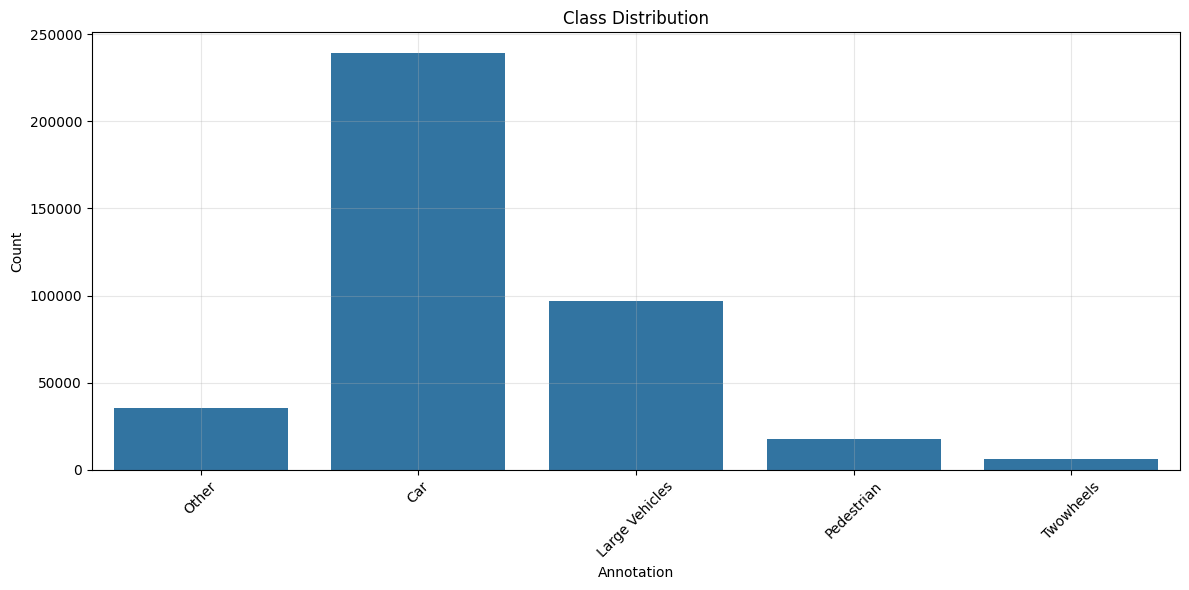

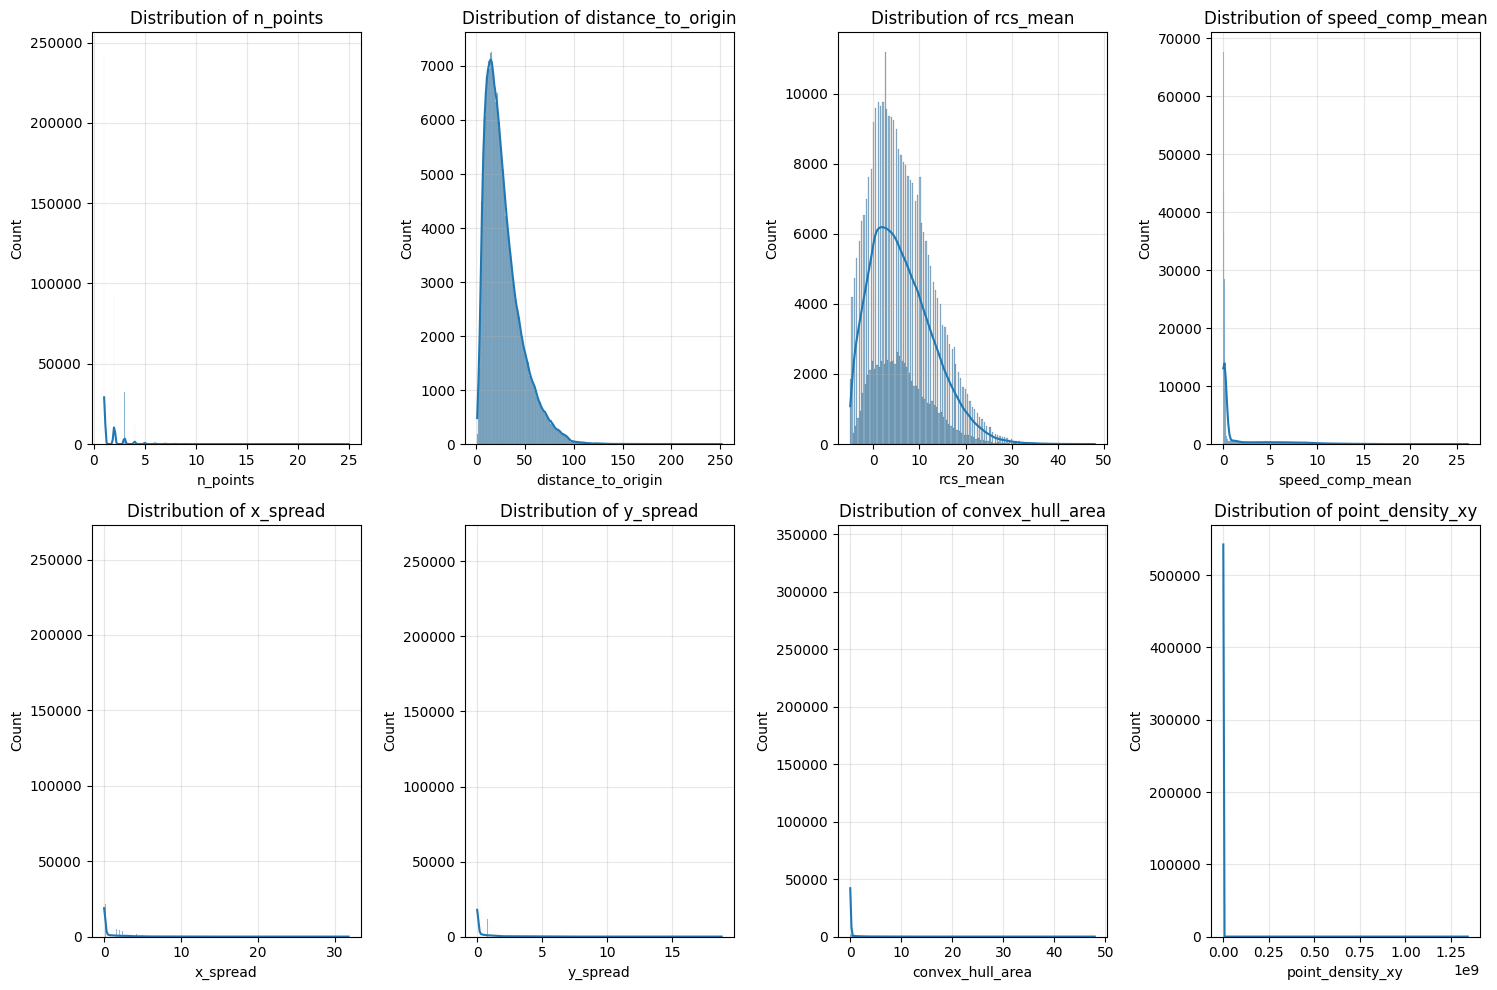

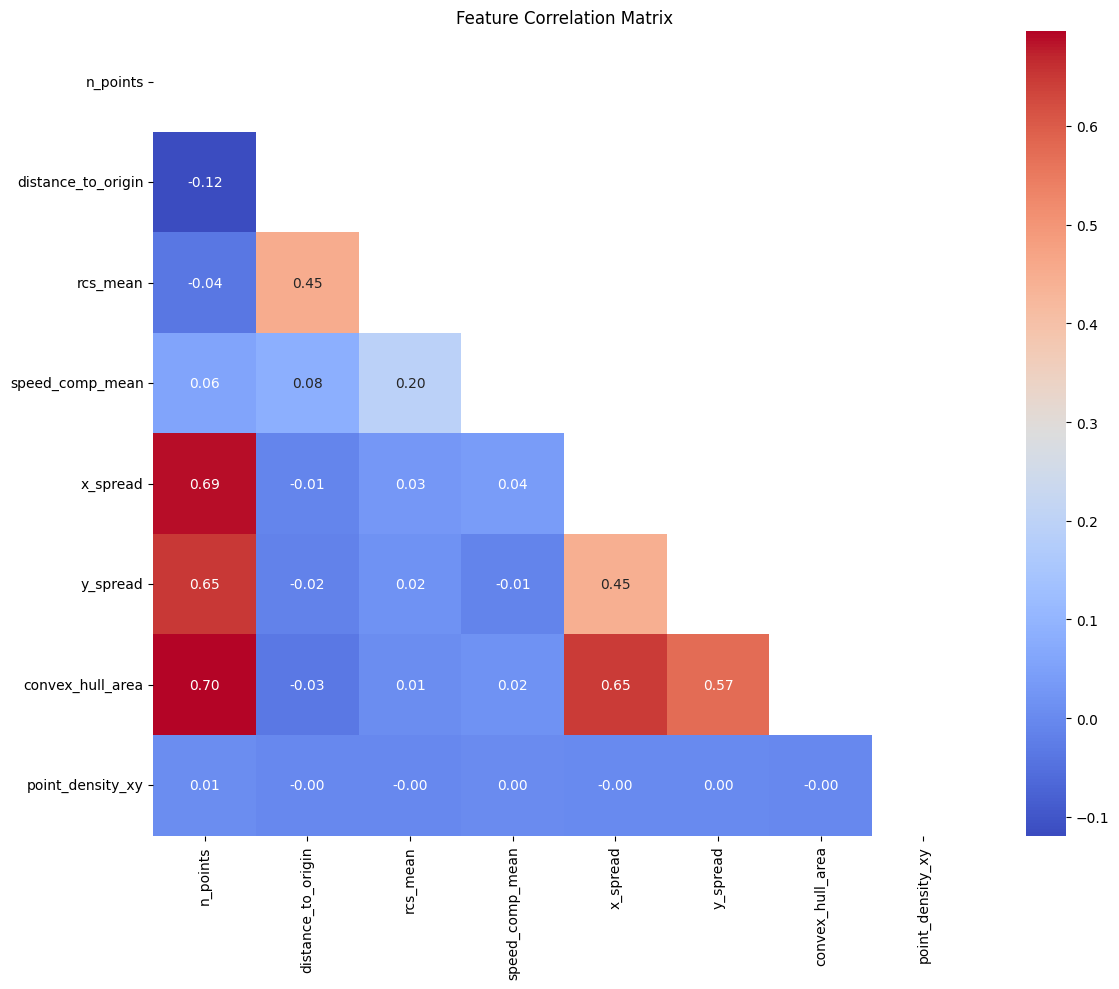

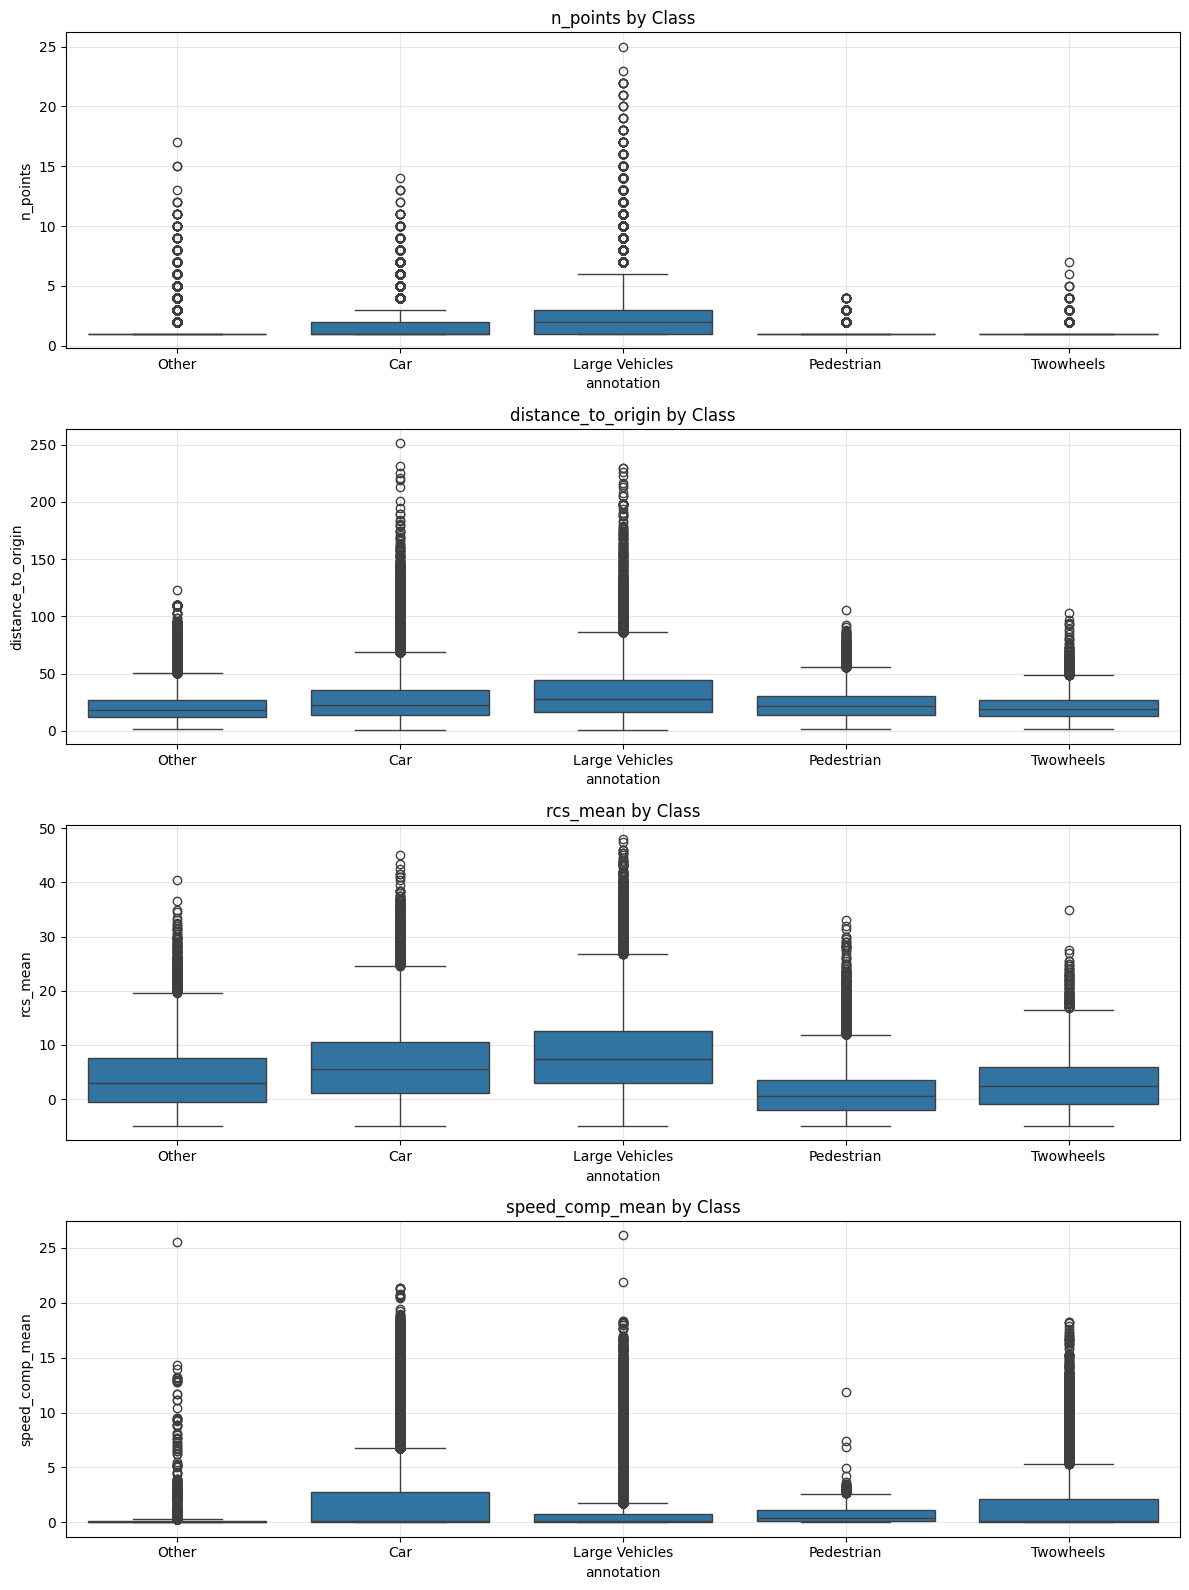

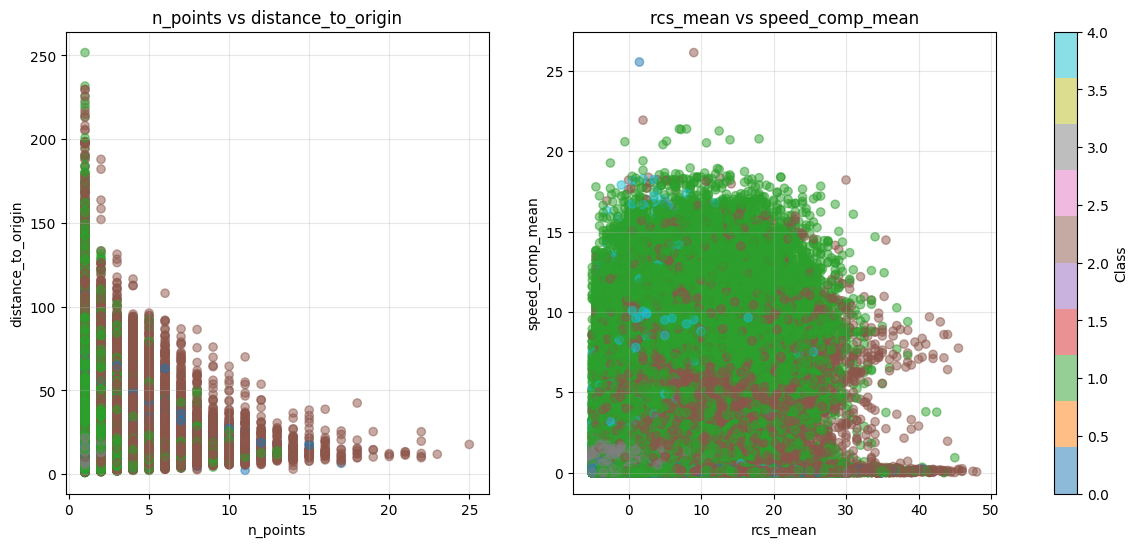

In [ ]:
if 'annotation' in features_df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(x='annotation', data=features_df)
    plt.title('Class Distribution')
    plt.xlabel('Annotation')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

important_features = [
    'n_points', 'distance_to_origin', 'rcs_mean', 'speed_comp_mean', 
    'x_spread', 'y_spread', 'convex_hull_area', 'point_density_xy'
]

plot_features = [f for f in important_features if f in features_df.columns]

if plot_features:
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(plot_features):
        plt.subplot(2, 4, i+1)
        sns.histplot(features_df[feature], kde=True)
        plt.title(f'Distribution of {feature}')
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if len(plot_features) > 1:
    plt.figure(figsize=(12, 10))
    corr_matrix = features_df[plot_features].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

if 'annotation' in features_df.columns and len(plot_features) > 0:
    # Get the most common classes for clarity
    top_classes = features_df['annotation'].value_counts().head(5).index.tolist()
    df_subset = features_df[features_df['annotation'].isin(top_classes)]
    
    # Select a smaller subset of features for clarity
    boxplot_features = plot_features[:4]  # Take first 4 features
    
    fig, axes = plt.subplots(len(boxplot_features), 1, figsize=(12, 4*len(boxplot_features)))
    
    for i, feature in enumerate(boxplot_features):
        ax = axes[i] if len(boxplot_features) > 1 else axes
        sns.boxplot(x='annotation', y=feature, data=df_subset, ax=ax)
        ax.set_title(f'{feature} by Class')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 2D scatter plots of selected feature pairs, colored by class
if 'annotation' in features_df.columns and len(plot_features) >= 2:
    # Use the subset with top classes for clarity
    if 'df_subset' not in locals():
        top_classes = features_df['annotation'].value_counts().head(5).index.tolist()
        df_subset = features_df[features_df['annotation'].isin(top_classes)]
    
    # Select a few feature pairs for visualization
    feature_pairs = [
        (plot_features[0], plot_features[1]),
        (plot_features[2], plot_features[3]) if len(plot_features) > 3 else (plot_features[0], plot_features[2])
    ]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    for i, (feat1, feat2) in enumerate(feature_pairs):
        scatter = axes[i].scatter(
            df_subset[feat1], 
            df_subset[feat2], 
            c=pd.factorize(df_subset['annotation'])[0], 
            alpha=0.5, 
            cmap='tab10'
        )
        axes[i].set_xlabel(feat1)
        axes[i].set_ylabel(feat2)
        axes[i].set_title(f'{feat1} vs {feat2}')
        axes[i].grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=axes, label='Class')
    plt.show()

---

In [ ]:
output_csv_path = 'nuscenes_objects_features_classification.csv'
features_df.to_csv(output_csv_path, index=False)
print(f"Full classification dataset saved to: {output_csv_path}")

Full classification dataset saved to: nuscenes_objects_features_classification.csv


In [ ]:
# Create a smaller version with only key features for quick testing
# Select important identifier columns
id_columns = ['instance_token', 'timestamp', 'scene_name']

if 'annotation' in features_df.columns:
    id_columns.append('annotation')

# Also include the original annotation if available
if 'original_annotation' in features_df.columns:
    id_columns.append('original_annotation')

if 'sensor' in features_df.columns:
    id_columns.append('sensor')

# Select a subset of important features (if they exist in our dataset)
feature_subset = [
    'n_points', 'distance_to_origin', 
    'x_mean', 'y_mean', 'z_mean',
    'x_spread', 'y_spread', 'z_spread',
    'bbox_area_xy', 'bbox_volume',
    'speed_comp_mean', 'speed_comp_std',
    'rcs_mean', 'rcs_std',
    'cov_ev_major_xy', 'cov_ev_minor_xy', 'cov_ev_ratio_xy',
    'convex_hull_area', 'point_density_xy', 'circularity',
    'flatness', 'linearity', 'sphericity',
    'stationary_ratio', 'quality_valid_ratio'
]

# Filter to include only existing columns
existing_features = [f for f in feature_subset if f in features_df.columns]
selected_columns = id_columns + existing_features

# Create the subset dataframe
subset_df = features_df[selected_columns]

# Save the subset
subset_csv_path = 'nuscenes_objects_features_classification_subset.csv'
subset_df.to_csv(subset_csv_path, index=False)
print(f"Subset classification dataset saved to: {subset_csv_path}")

print(f"\nDataset shapes:")
print(f"- Full dataset: {features_df.shape}")
print(f"- Subset dataset: {subset_df.shape}")
print(f"Selected features for subset: {existing_features}")

Subset classification dataset saved to: nuscenes_objects_features_classification_subset.csv

Dataset shapes:
- Full dataset: (395341, 91)
- Subset dataset: (395341, 30)
Selected features for subset: ['n_points', 'distance_to_origin', 'x_mean', 'y_mean', 'z_mean', 'x_spread', 'y_spread', 'z_spread', 'bbox_area_xy', 'bbox_volume', 'speed_comp_mean', 'speed_comp_std', 'rcs_mean', 'rcs_std', 'cov_ev_major_xy', 'cov_ev_minor_xy', 'cov_ev_ratio_xy', 'convex_hull_area', 'point_density_xy', 'circularity', 'flatness', 'linearity', 'sphericity', 'stationary_ratio', 'quality_valid_ratio']
